<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/Advanced/NoveltyCoverage.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install aitk --upgrade --quiet

# Evolving _Novel_ Robot Controllers

In this essay, we explore using Novelty Search to measure the fitness for a Genetic Algorithm that is evolving neural networks for robot control.


For this demonstration, we will need:

* `GeneticAlgorithm` and `NoveltySearch` defined in aitk.algorithms
* `World`, `Scribbler`, `RangeSensor` from aitk.robots 
* `SimpleNetwork` from aitk.networks
* And a few other support functions from our utilities

We import everything needed below:

In [1]:
from aitk.algorithms import GeneticAlgorithm, NoveltySearch
from aitk.robots import World, Scribbler, RangeSensor
from aitk.networks import SimpleNetwork
from aitk.robots.utils import distance
from aitk.utils import gallery, Grid, Color
import random
import math

## Novelty Search

Joel Lehman and Kenneth Stanley first introduced the novelty search algorithm in a 2008 paper entitled *Exploiting open-endedness to solve problems through the search for novelty* which was published in the proceedings of the ALIFE conference.

Rather than searching for a particular objective, the goal of novelty search is to discover unique **behaviors**. It accomplishes this by maintaining an archive of previous behaviors it has found.  The archive has a limited size, and only behaviors that are deemed novel enough are stored in the archive. The novelty of a behavior is defined as the *normalized average distance from its k-nearest neighbors* in the archive. Because novelty is a normalized quantity it will always be in the range `[0,1]`. A behavior must have a novelty score above a given threshold to be retained in the archive. 

### Applying Novelty Search 

We are interested in developing robot behaviors to move about in a small environment without getting stuck and visiting as much of the environment as possible (like a vacuuming robot). 

We will impose a grid on top of the environment and we will define a behavior as the sequence of *newly visited* grid locations. Our grid will be 10x10 so the maximum possible length of a behavior sequence is 100.  The robot will always start in the center and be allowed to move around for 60 seconds. Some behavior sequences might be quite short, for instance if the robot simply spins in the center only visiting a few cells.  We will pad all behavior sequences with the same point to ensure that they are all equivalent in length.

Then to calculate novelty we will look at the distance between the k nearest neighbor behavior sequences in the archive. If the average distance from these k nearest neighbors is high enough, then the behavior is considered novel.

The following function is used to determine a quick upper bound on the maximum possible distance between two behavior sequences. This is needed to compute the *normalized* average distance. It simply calculates the maximum distance between two locations in the grid, and multiplies that times the number of maximum possible number of moves.

In our example, with a 10x10 grid, the minimum point is (0,0), the maximum point is (9,9), and the number of points is 100.

In [2]:
def get_max_distance(grid_size):
    """Get the maximum possible distance between two behaivors"""
    min_pt = (0, 0)
    max_pt = (grid_size - 1, grid_size - 1)
    num_pts = grid_size * grid_size 
    return distance(min_pt, max_pt) * num_pts

In [3]:
get_max_distance(10)

1272.7922061357856

### Determining parameter settings

When initializing novelty search one must determine appropriate settings for the following parameters:

Parameter|Description|Current setting
---------|-----------|---------------
k        |size of neighborhood| 15
limit    |size of archive| 100
threshold|min normalized avg dist|0.075
max_dist |max dist between behaviors|1272

If *k* is too low, the criteria for novelty may be too easy to achieve.

If the *threshold* is too high, no behavior will be considered novel enough and the archive will never grow beyond the first k behaviors.

As with any machine learning algorithm finding the sweet spot for these parameters is not always straight forward and may require experimentation.


## The Genetic Algorithm

The [Genetic Algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is an approach inside the category of machine learning systems called [Evolutionary Algorithms](https://en.wikipedia.org/wiki/Evolutionary_algorithm) (EA). For this essay, we will use the GA as follows:

1. We will define a `gene` to be a floating-point number that represents the weight or bias of a Neural Network.
2. We will define a `chromosome` as a sequence of genes. The chromosome (sometimes called a `geneotype`) will represent all of the weights and biases of a network.
3. A`population` will be composed of a set of random chromosomes.

The length of the chromosome is determined by the size of the Neural Network. Therefore, we will call `self.build_model()` (defined below) and see how many weights it has. 

We'll use a ring of 16 laser sensors as senses. We create a small simulated world (200 x 200) to allow the robot to move around.

The basic idea is that we will have a list of weights (the chromosome) that we load into the neural network. The sensors will be read, and propagated through the neural network. The output of the neural network will be interpreted as movement controls. We'll let the neural network "drive" the robot around the world starting from the center of the world.  

In [63]:
class NoveltyGA(GeneticAlgorithm):
    """
    An example of using the GeneticAlgorithm class to 
    evolve the weights of a neural network to control 
    a simulated robot using Novelty Search to determine
    the fitness.
    """
    def __init__(self, popsize, sensors=16, grid_size=10):
        self.novelty_search = NoveltySearch(
            k=15, 
            limit=100, 
            threshold=0.075,
            max_dist=get_max_distance(grid_size),
        )
        self.pad = (4,4) # the point used to pad behavior sequences
        self.show = False
        self.sensors = sensors
        self.world = World(200, 200)
        self.robot = Scribbler(x=100, y=100, a=87, 
                              max_trace_length=60)
        # We add a ring of RangeSensors, 8cm from
        # the robot center, starting and ending 
        # at the back of the robot
        # with 75cm max range, and sensor width 0
        # which makes it a laser range finder
        self.robot.add_device_ring(
            RangeSensor, 8, -180, 180, 
            self.sensors, max=100, width=0)
        self.world.add_robot(self.robot)
        self.network = self.build_model()
        # Length of a chromosome:
        length = len(self.network.get_weights(flat=True))
        super().__init__(length, popsize)

As mentioned, a chromosome will be a sequence of floating-point numbers, between -2 and +2. When we mutate such a gene, we will increase or decrease it a small amount. To define these two aspects of a gene, we define the following methods:

In [43]:
class NoveltyGA(NoveltyGA):        
    def make_random_gene(self):
        """
        Generate a random weight for the neural network.
        """
        # range of [-2, +2]
        return 2 - random.random() * 4
    
    def mutate_gene(self, gene):
        """
        Given a gene, mutate it a little.
        """
        # range of [-0.5, +0.5]
        return gene + (0.5 - random.random())

## The Fitness Function

To use a GA we need to define a `fitness function`. A fitness function tests a chromosome in the simulated world, and returns a value that represents how "apt" (or fit) it is relative to the other chromosomes in the population at this generation.

### Aligning fitness with novelty

Typically a fitness function will measure how close the model is to achieving some fixed goal.  For example, when evolving coverage, a reasonable fixed goal is to find a controller that achieves the highest percentage of visited grid locations. 

In these experiments, as discussed above, we will instead keep track of the sequence of **new** grid locations visited, and the more unique the sequence, the more fitness it will receive. 

Rather than searching for the single best coverage we will instead be searching for the widest range of patterns of movement, and along the way we hope to also find some good coverage patterns. 

In [44]:
class NoveltyGA(NoveltyGA):        
    def fitness(self, chromosome, index=None, seconds=60, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        """During search, fitness is based on novelty"""
        self.show = show
        self.network.set_weights(chromosome)
        self.robot.set_pose(100, 100, 87)
        self.grid = Grid((10, 10), self.world)
        self.world.seconds(seconds, self.controller, interrupt=interrupt, 
                           real_time=real_time, show=show, show_progress=show_progress, 
                           quiet=quiet)
        score = self.novelty_search.check_archive(
            self.grid.get_sequence(self.pad, 10 * 10),
            chromosome)
        return score

    def test_coverage(self, chromosome, seconds):
        """During testing, see how well behavior covers grid"""
        self.network.set_weights(chromosome)
        self.robot.set_pose(100, 100, 87)
        self.grid = Grid((10,10), self.world)
        self.world.seconds(seconds, self.controller, interrupt=True, 
                           real_time=False, show=True, show_progress=True, 
                           quiet=True)
        return self.grid.analyze_visits()

We can now add some methods for the specific problem:

* build_model - creates the neural network that takes as input the number of sensors, and outputs the movement commands (one for translate, one for rotate)
* controller - the method to drive the robot
* get_sensors - a convenience method to get the sensor readings from the range sensors as a list
* get_move - a method that takes the input to the network (the sensor readings) and propagates them through the network to get the output values, which are scaled to [-1, +1]

In [45]:
class NoveltyGA(NoveltyGA):        
    def build_model(self):
        """
        We build a simple network. 
        """
        return SimpleNetwork(
            self.sensors,
            4,
            2,
            activation="sigmoid"
        )
        
    def controller(self, world):
        """
        The controller for the robot.
        Updates the grid for visited locations.
        """
        sensors = self.get_sensors()
        output = self.get_move(sensors)
        self.robot.move(output[0], output[1])
        x, y, a = self.robot.get_pose()
        self.grid.update(x, y)
        self.grid.draw()
        if self.robot.stalled:
            return True
        
    def get_sensors(self):
        """
        We return the sensors from the robot.
        Make close readings be closer to 1.
        """
        return [1-sensor.get_reading() 
                for sensor in self.robot]
    
    def get_move(self, sensors):
        """
        Given the dataset (a single )
        """
        # Propagate takes a single pattern:
        output = self.network.propagate(
            sensors, show=self.show)
        # Scale the output in [-1, 1]
        return 1 - output * 2
    

Now, we are ready to create a GA. We'll define the population size to be 30, which isn't too small, but big enough to evolve a solution in a few minutes.

In [46]:
ga = NoveltyGA(popsize=30)

Random seed set to: 440313
Genetic algorithm
  Chromosome length: 78
  Population size: 30


We can observe the world with:

In [47]:
ga.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

We can also dynamically observe the network:

In [48]:
ga.network.watch()

HTML(value='<div style="outline: 5px solid #1976D2FF; width: 400px; height: 324px;"><svg id=\'keras-network\' …

To test, we make a random chromosome:

In [49]:
chromosome = ga.make_random_chromosome()

Let's see how a random set of weights does in covering the grid:

In [50]:
ga.fitness(
    chromosome, 
    seconds=5,
    show=True, 
    real_time=True)

1.0

Notice that there is a grid imposed on the world.  As the robot visits cells within this grid they light up. 

The first time you test a chromosome the fitness will be 1.0 indicating that this is extremely novel as it is the first example.

However, the second time for this exact sequence, you should get a fitness of 0.0 as it is an exact duplicate and not novel at all.

In [51]:
ga.fitness(
    chromosome, 
    seconds=5,
    show=True, 
    real_time=True)

0.0

If the next random chromosome produces a similar behavior, such as spinning in the center, it's fitness will be quite low.  Only new behaviors will elicit high fitness values when using novelty search to score the fitness.

To compute the novelty we need to get the path of the robot through the grid starting with (5,4) to its end position. 

In [52]:
ga.grid.get_sequence()

[(5, 5), (4, 5)]

The sequence only includes the first time it encounters a grid locations. 

To compare sequences for novelty, we pad the sequence with the same point to get a length of 100.

In [53]:
s = ga.grid.get_sequence(ga.pad, 10 * 10)
print(f"Total length is: {len(s)}")
print(f"First 10 items in sequence are: {s[:10]}")

Total length is: 100
First 10 items in sequence are: [(5, 5), (4, 5), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]


Each time we compute the fitness, it may update the archive based on the novelty of the sequence. Remember that the novelty of a sequence is determined by its average distance from its k-nearest neighbors in the archive.  Initially, all behaviors will automatically be added to the archive until its size is at least k.

## Checkpoint 1

Why is important to place the robot in exactly the same place facing exactly the same direction each time we compute the fitness?

## Checkpoint 2

Why is it important to pad the sequences with the same point?

## Evolving

To run 10 generations (plus one to test initial population) with a population of size 30 for 60 seconds each will take a significant amount of simulated time. 

We can get a big speed up by not watching the simulator or the network while we run evolution. You can run without watching by setting `show=False`.

However, the grid will light up showing you the grid locations visited by each neural network controller in the GA's population as it is evaluated for fitness. This will give you a sense of how the evolution is proceeding over time.

In addition, after each generation is complete a short summary message is printed.

In [54]:
%%time
ga.reset()
ga.world.reset()
bestFound = ga.evolve(
    generations=10, 
    crossover_rate=0.0, 
    mutation_rate=0.6, 
    elite_percent=0, 
    seconds=60,
    show=False,
) 

Using random seed: 440313
  Maximum number of generations: 10
  Crossover rate: 0.0
  Mutation rate: 0.6
  Elite percentage 0
  Elite count: 0
Generation    0 Best fitness 0.14
Generation    1 Best fitness 0.15
Generation    2 Best fitness 0.15
Generation    3 Best fitness 0.15
Generation    4 Best fitness 0.15
Generation    5 Best fitness 0.15
Generation    6 Best fitness 0.15
Generation    7 Best fitness 0.15
Generation    8 Best fitness 0.15
Generation    9 Best fitness 0.15
Generation   10 Best fitness 0.15
Max generations reached
CPU times: user 3min 43s, sys: 733 ms, total: 3min 44s
Wall time: 3min 45s


### Analysis

Normally when analyzing a GA we would look at the best and average fitness in the population over time. But in this case, where we are seeking novel behaviors rather than a typical fixed goal, this type of analysis is less pertinent.  When doing novelty search we would expect that as the generations proceed it will be harder and harder to find novel behaviors. Thus the best will stagnate fairly early on, but that doesn't mean that the GA has stopped discovering novel robot controllers.  It just means that their novelty scores are lower because more and more of the possible behaviors have been explored.

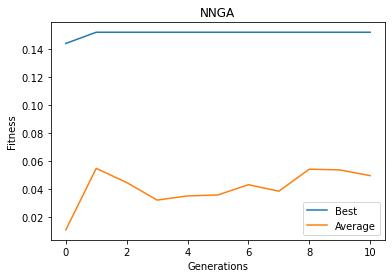

In [55]:
ga.plot_stats("NNGA")

When doing novelty search, it is more interesting to We look at how the archive grows over time. There will always be at least k behaviors in the archive. Typically, the first k behaviors may not be that interesting because the archive needs to reach this length before novelty can start to be measured. How many more novel behaviors were found during the search?

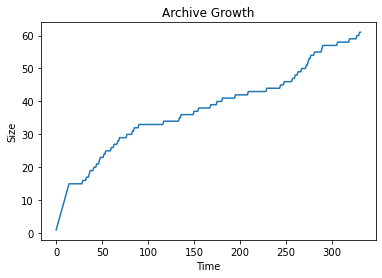

In [56]:
ga.novelty_search.plot_growth()

If the archive size is not much larger than k, then we may need to try different novelty search parameter settings.  In particular, we may want to decrease the threshold, making it easier for behaviors to be considered novel.

Let's test all of the behaviors in the archive that were added _after_ the first k (remember that the initial behaviors aren't necessarily that novel, but are added to get the archive started).

In [57]:
images = []
start_index = ga.novelty_search.k
stop_index = len(ga.novelty_search.archive)
            
for i in range(start_index, stop_index):
    chromo = ga.novelty_search.archive[i][2]
    coverage = ga.test_coverage(chromo, 60)
    print(f"archive chromo {i} coverage {coverage}")
    images.append(ga.world.get_image())

archive chromo 15 coverage 0.43
archive chromo 16 coverage 0.39
archive chromo 17 coverage 0.44
archive chromo 18 coverage 0.42
archive chromo 19 coverage 0.34
archive chromo 20 coverage 0.42
archive chromo 21 coverage 0.31
archive chromo 22 coverage 0.4
archive chromo 23 coverage 0.44
archive chromo 24 coverage 0.33
archive chromo 25 coverage 0.42
archive chromo 26 coverage 0.43
archive chromo 27 coverage 0.44
archive chromo 28 coverage 0.31
archive chromo 29 coverage 0.41
archive chromo 30 coverage 0.43
archive chromo 31 coverage 0.38
archive chromo 32 coverage 0.34
archive chromo 33 coverage 0.37
archive chromo 34 coverage 0.34
archive chromo 35 coverage 0.44
archive chromo 36 coverage 0.37
archive chromo 37 coverage 0.46
archive chromo 38 coverage 0.42
archive chromo 39 coverage 0.34
archive chromo 40 coverage 0.34
archive chromo 41 coverage 0.35
archive chromo 42 coverage 0.43
archive chromo 43 coverage 0.38
archive chromo 44 coverage 0.4
archive chromo 45 coverage 0.42
archive ch

Although we were searching broadly for novel behaviors, the GA typically does find many behaviors that do produce reasonably good coverage as well.

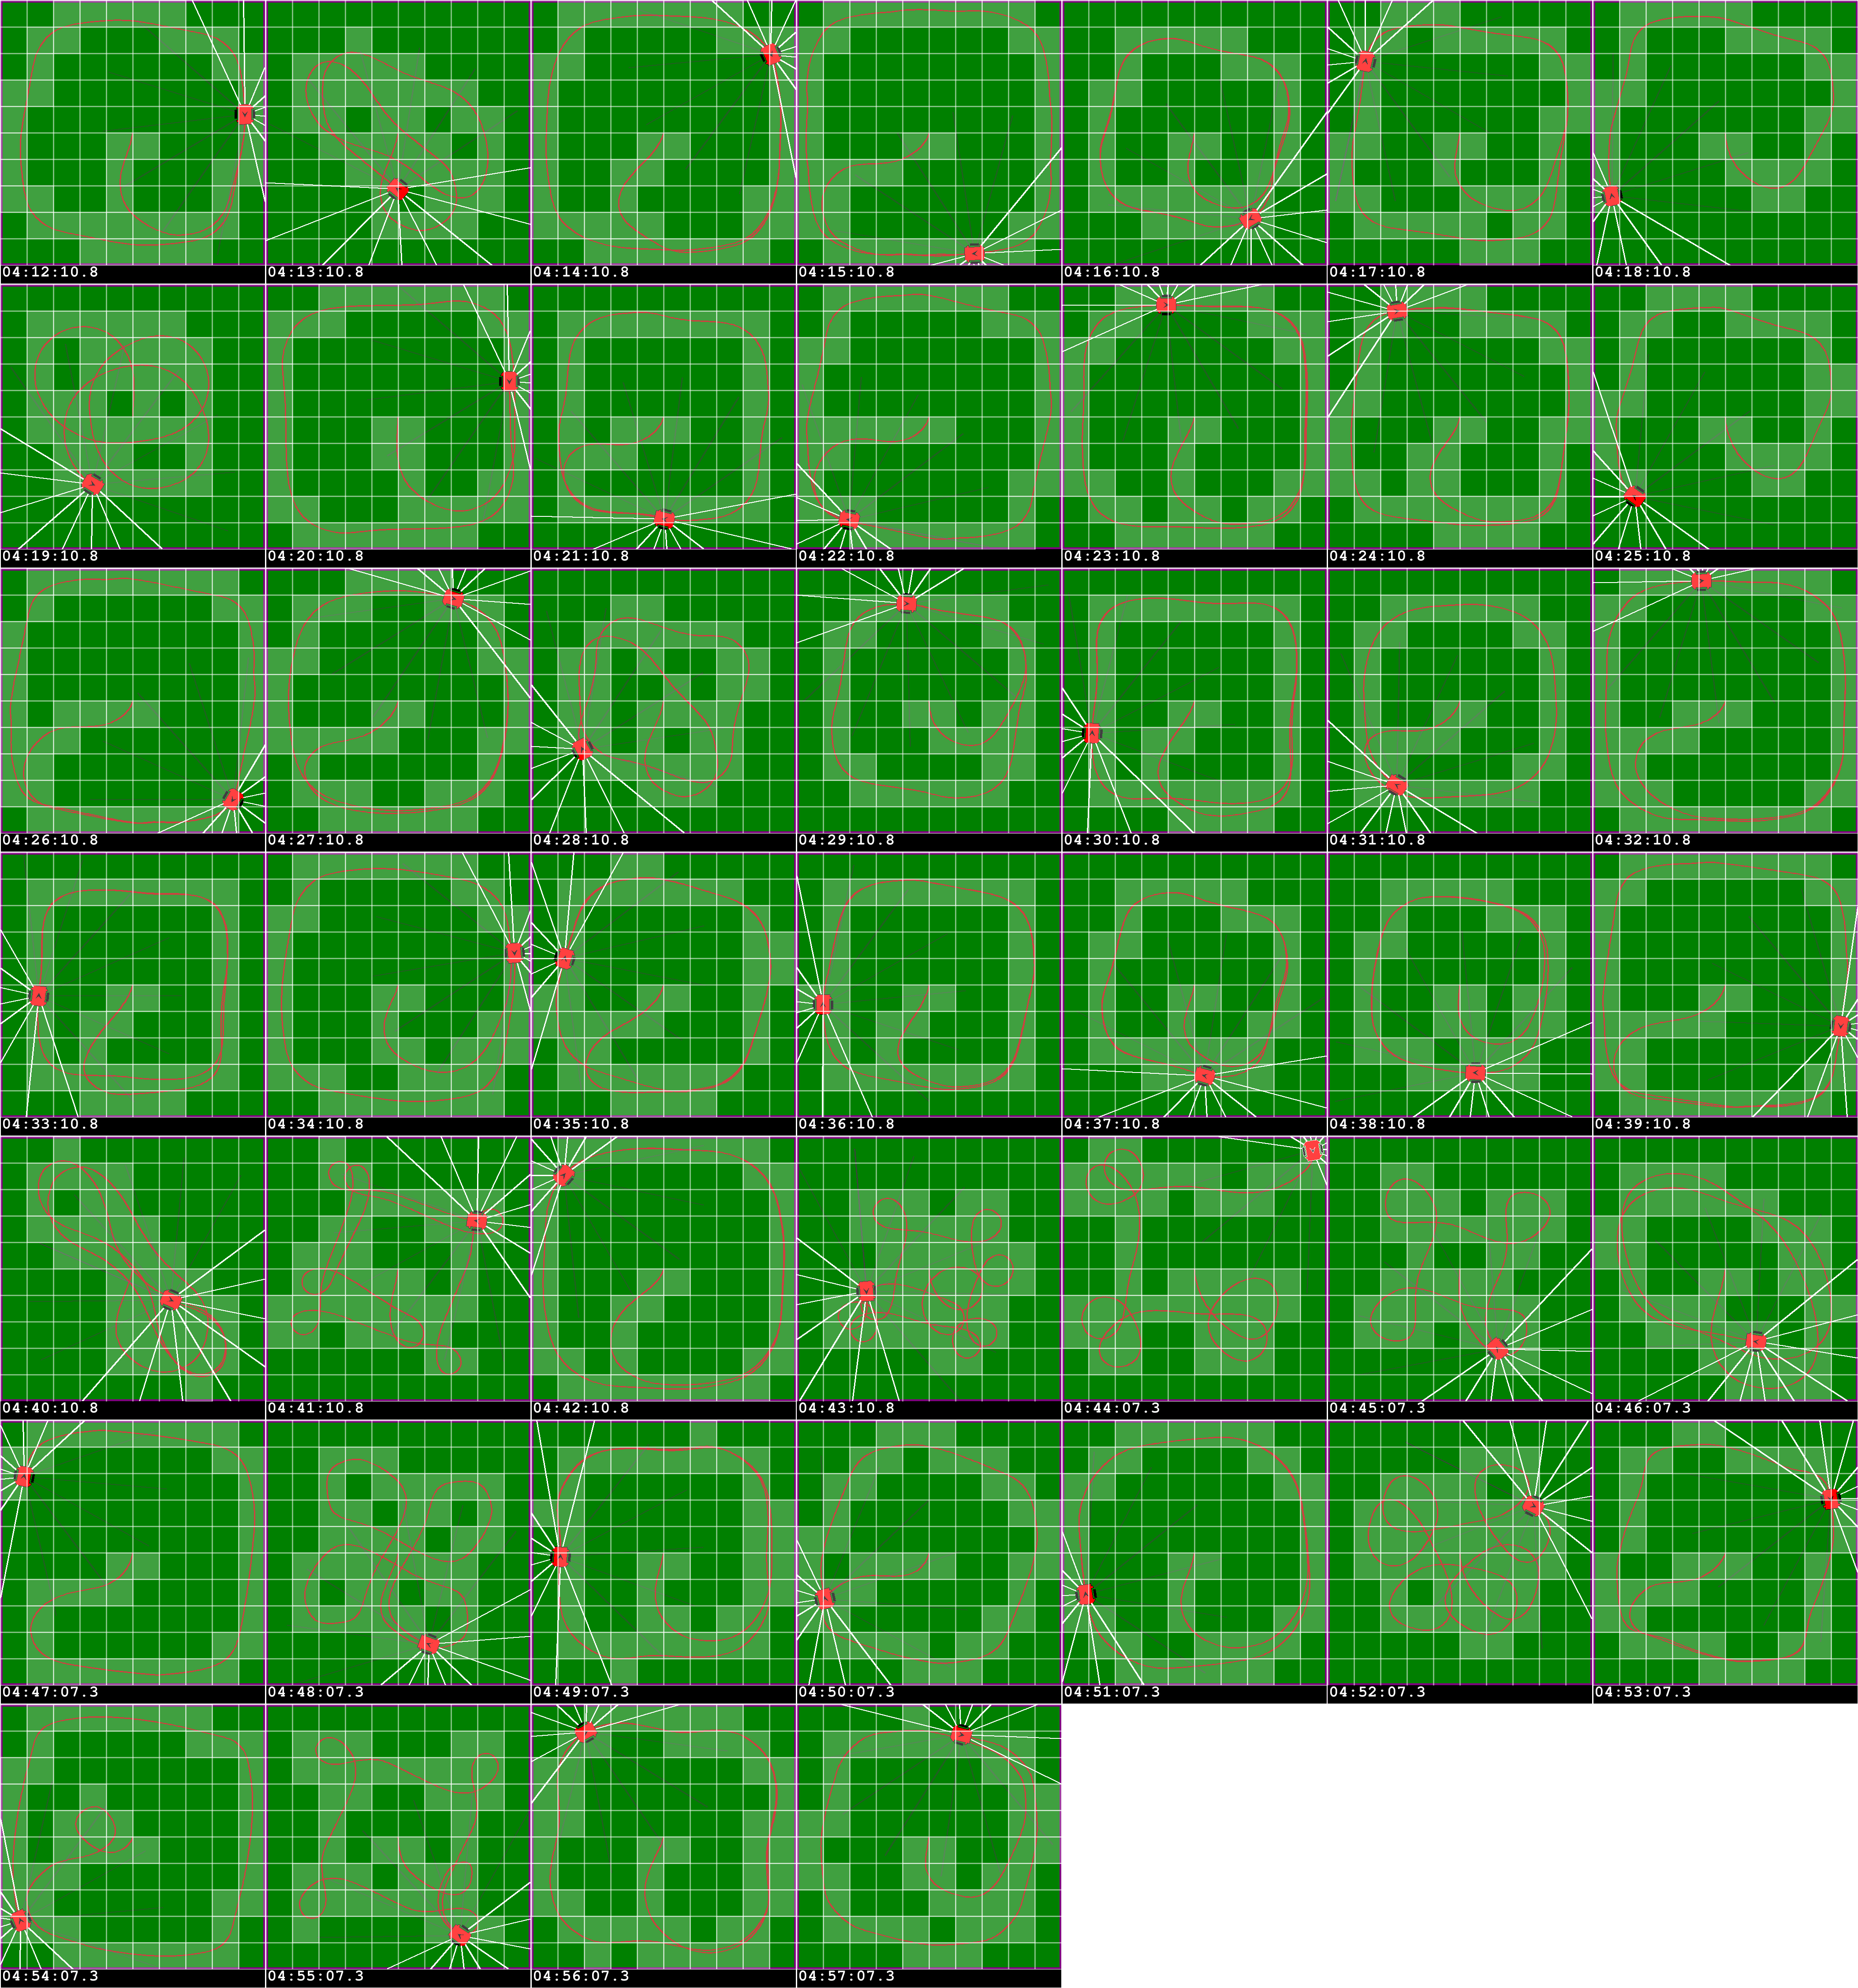

In [58]:
gallery(images)

Some of the behaviors found are quite interesting.  You can explore one in more depth by letting it run longer than the 60 seconds used during fitness testing in evolution. Try letting it run twice or three times as long (the time limit is the second parameter in the test_coverage method below).  Does it get even better coverage when given more time to run?

In [62]:
archive_index = 15 # replace this one of your choice
chromo = ga.novelty_search.archive[archive_index][2]
coverage = ga.test_coverage(chromo, 180)
print(coverage)

0.43


## Conclusions

Lehman and Stanley note that novelty search is best suited for domains that have:

* Deceptive fitness landscapes
* Intuitive behavior characterization
* Constraints on the possible set of behaviors

For the coverage task explored here, we constrained the set of possible behaviors by imposing a grid on top of the world, and then limited the behavior description to the total number of grid locations. 

Although this task may not be deceptive, there are a huge diversity of possible successful behaviors. Applying novelty search to this task allows the GA to better find a collection of both unique and successful coverage strategies.